# Sede: La Popa

In [1]:
%load_ext autoreload
%autoreload 2

from Ubidots_library_acruz import Ubidots

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px


import config as cfg
import Report_library as Report

## Configuration

In [4]:
USE_CELSIA_PALETTE = cfg.USE_CELSIA_PALETTE
lst_primary_palette = cfg.lst_primary_pallete
lst_secondary_palette = cfg.lst_secondary_palette
primary_palette = sns.color_palette(lst_primary_palette)
secondary_palette = sns.color_palette(lst_secondary_palette)
lst_big_colors = lst_primary_palette + lst_secondary_palette
big_palette = sns.color_palette(lst_big_colors)
CELSIA_FONT = cfg.CELSIA_FONT

ALLOWED_DATE_OVERLAP = cfg.ALLOWED_DATE_OVERLAP
device_group_label = cfg.DEVICE_GROUP_LABEL
wide_figure_size = cfg.WIDE_FIGURE_SIZE

LST_NIGHTTIME_HOURS = cfg.lst_nighttime_hours
confidence_interval = cfg.CONFIDENCE_INTERVAL
dct_dow = cfg.dct_dow

ALL_VARIABLE_LABELS = cfg.ALL_VARIABLE_LABELS
BLACKLISTED_VARIABLE_LABELS = cfg.BLACKLISTED_VARIABLE_LABELS
ACTIVE_ENERGY_LABELS = cfg.ACTIVE_ENERGY_LABELS
ACTIVE_POWER_LABELS = cfg.ACTIVE_POWER_LABELS
ACTIVE_ENERGY_LUMP_LABEL = cfg.ACTIVE_ENERGY_LUMP_LABEL
ACTIVE_POWER_LUMP_LABEL = cfg.ACTIVE_POWER_LUMP_LABEL
TOTAL_ACTIVE_ENERGY_LABEL = cfg.TOTAL_ACTIVE_ENERGY_LABEL
TOTAL_ACTIVE_POWER_LABEL = cfg.TOTAL_ACTIVE_POWER_LABEL
TOTAL_REACTIVE_ENERGY_LABEL = cfg.TOTAL_REACTIVE_ENERGY_LABEL

SUB_STR = cfg.SUB_STR

DATA_FREQUENCY = cfg.DATA_FREQUENCY
DATE_INTERVALS_TO_DISCARD = cfg.DATE_INTERVALS_TO_DISCARD
df_request_dates = pd.read_excel('request_dates.xlsx')
df_request_dates.set_index('device', inplace=True)

use_pickled_data = cfg.USE_PICKLED_DATA


# If this isn't done before plotting with Seaborn
# the first plot won't be the right size
plt.figure()
plt.show()
sns.set_context('notebook')
sns.set_style("whitegrid")
sns.set(
    rc={'figure.figsize': wide_figure_size},
    font=CELSIA_FONT
)
plt.close()
pio.renderers.default = "notebook"

# Create the colormap for all heatmaps
colorlist=[big_palette[1], big_palette[0], big_palette[4]]
newcmp = LinearSegmentedColormap.from_list('my_cmap', colors=colorlist, N=256)


## POI level configuration
device_label = 'hc-la-popa'
PICKLED_DATA_FILENAME = 'parsed_response_Popa.pkl'
LST_DEVICE_ID_TO_REQUEST = ['6218e8fd5504633b764cecc0']

BASELINE_DATE_INTERVAL = {
    'start' : df_request_dates.loc[device_label, 'bl_start'],
    'end' : df_request_dates.loc[device_label, 'bl_end']
}
STUDY_DATE_INTERVAL = {
    'start' : df_request_dates.loc[device_label, 'st_start'],
    'end' : df_request_dates.loc[device_label, 'st_end']
}

<Figure size 1250.06x550.028 with 0 Axes>

## Data loading

In [5]:
# check for intersecting study and baseline intervals before making any requests
Report.check_intervals(BASELINE_DATE_INTERVAL, STUDY_DATE_INTERVAL, ALLOWED_DATE_OVERLAP)

dct_available_devices = Report.get_available_devices(device_group_label)

if (LST_DEVICE_ID_TO_REQUEST==None):
    LST_DEVICE_ID_TO_REQUEST = list(dct_available_devices.keys())

df_vars = Report.get_available_variables(LST_DEVICE_ID_TO_REQUEST)
df_vars['device_label'] = df_vars['device_id'].map(dct_available_devices)
is_blacklisted = df_vars['variable_label'].isin(BLACKLISTED_VARIABLE_LABELS)
df_vars_to_request = df_vars[~is_blacklisted].reset_index(drop=True)
df_vars_req_wide = df_vars_to_request.pivot(index='variable_label', columns='device_label', values='variable_id')

DCT_VAR_ID_TO_LABEL = dict(zip(list(df_vars['variable_id']), list(df_vars['variable_label'])))
SET_LABELS_TO_REQUEST = set(df_vars_to_request['variable_label'].sort_values())
VAR_IDS_TO_REQUEST = list(df_vars_to_request['variable_id'])




df = None
if (use_pickled_data is True):
    df = pd.read_pickle(PICKLED_DATA_FILENAME)
else:
    # A user might select baseline and study intervals
    # which are sufficiently far apart that fetching
    # the data in between is very inefficient.
    # So it's best to make a request per interval.
    response_bl = Report.make_request(
        VAR_IDS_TO_REQUEST, 
        BASELINE_DATE_INTERVAL, 
    )

    response_st = Report.make_request(
        VAR_IDS_TO_REQUEST, 
        STUDY_DATE_INTERVAL, 
    )
    
    df = Report.parse_response(response_bl, response_st, DCT_VAR_ID_TO_LABEL)
    pd.to_pickle(df, PICKLED_DATA_FILENAME)

# TODO: add pickling to this
df_coords = Report.get_coords_dataframe(LST_DEVICE_ID_TO_REQUEST)

Report.show_response_contents(df)

The response contains:
[
    "ea-total",
    "ea-equipos-de-climatizacion",
    "pa-equipos-de-climatizacion",
    "pa-equipos-verticales",
    "pa-iluminacion-patio-constructor",
    "pa-iluminacion-principal",
    "pa-car-center",
    "pa-area-de-corte",
    "ea-equipos-verticales",
    "ea-car-center",
    "ea-area-de-corte",
    "ea-iluminacion-patio-constructor",
    "ea-iluminacion-principal"
]
[
    "hc-la-popa"
]


## Preprocessing

In [6]:
# Discard first entry before cleaning as it might not belong to interval
# sort by datetime to guarantee chronological order when dropping rows
df.sort_values(by=['datetime', 'device', 'variable'], inplace=True)
df = Report.subset_drop_first_n_rows(df, subset_a='device', subset_b='variable', n_rows=1)

if len(DATE_INTERVALS_TO_DISCARD)>0:
    df = Report.subset_discard_date_intervals(df, DATE_INTERVALS_TO_DISCARD)

# TODO: fix this line. As a temp measure we are disallowing negative active
# power and active energy. This is not actually valid for some systems
# which may contain solar panels, for instance.
is_ea_or_pa = (df['variable'].isin(ACTIVE_ENERGY_LABELS + ACTIVE_POWER_LABELS))
is_negative = (df['value'] < 0)
df.loc[is_negative, 'value'] = np.nan

df = Report.double_subset_rolling_clean(
    df, 
    subset_a='device', 
    subset_b='variable', 
    clean_on='value'
)

# plotting requires day of week and hour of day labels
df = Report.apply_datetime_transformations(df)

df_bl, df_st = Report.split_into_baseline_and_study(df, BASELINE_DATE_INTERVAL, STUDY_DATE_INTERVAL)

In [7]:
# BASELINE
df_bl = df.loc[BASELINE_DATE_INTERVAL['start']:BASELINE_DATE_INTERVAL['end']]

df_bl_ea = df_bl[df_bl["variable"].isin(ACTIVE_ENERGY_LABELS)]
df_bl_pa = df_bl[df_bl["variable"].isin(ACTIVE_POWER_LABELS)]

df_bl_total_ea = df_bl[df_bl["variable"].isin([TOTAL_ACTIVE_ENERGY_LABEL])]
df_bl_total_er = df_bl[df_bl["variable"].isin([TOTAL_REACTIVE_ENERGY_LABEL])]
df_bl_ea_night = df_bl_ea[df_bl_ea["hour"].isin(LST_NIGHTTIME_HOURS)]


if df_bl['variable'].str.contains(TOTAL_ACTIVE_POWER_LABEL).any():
    df_bl_total_pa = df_bl[df_bl["variable"].isin([TOTAL_ACTIVE_POWER_LABEL])]
else:
    # To find total power we must first subset resample by
    # variable (to avoid mixing vars during resampling),
    # using a mean (power is not cummulative, so no sum)
    # and then aggregated by datetime with a sum
    # (hourly resampled power is a good proxy for energy).
    # NaNs must be dropped to recover as many hours as possible.
    df_bl_total_pa = Report.subset_resample(
        df_bl_pa.dropna(how='any'),
        agg_func=Report.assemble_aggregator(list(df_bl_pa.columns), np.mean, 'last'),
        subset='variable',
        freq=DATA_FREQUENCY
    ).groupby('datetime').sum()
    df_bl_total_pa['variable']=TOTAL_ACTIVE_POWER_LABEL


# power must use mean() and not sum() because it's not a cummulative variable
df_bl_pa_hourly = df_bl_pa.groupby(by=["variable"]).resample('1h').agg({'value':np.mean}).round(2).reset_index().set_index('datetime')
df_bl_pa_hourly = Report.apply_datetime_transformations(df_bl_pa_hourly)

df_bl_ea_hourly = df_bl_ea.groupby(by=["variable"]).resample('1h').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_ea_hourly = Report.apply_datetime_transformations(df_bl_ea_hourly)

df_bl_ea_daily = df_bl_ea.groupby(by=["variable"]).resample('1D').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_ea_daily = Report.apply_datetime_transformations(df_bl_ea_daily)

df_bl_ea_monthly = df_bl_ea.groupby(by=["variable"]).resample('1M').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_ea_monthly = Report.apply_datetime_transformations(df_bl_ea_monthly)

df_bl_total_pa_hourly = df_bl_total_pa.groupby(by=["variable"]).resample('1h').agg({'value':np.mean}).round(2).reset_index().set_index('datetime')
df_bl_total_pa_hourly = Report.apply_datetime_transformations(df_bl_total_pa_hourly)

df_bl_total_ea_hourly = df_bl_total_ea.groupby(by=["variable"]).resample('1h').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_total_ea_hourly = Report.apply_datetime_transformations(df_bl_total_ea_hourly)

df_bl_total_ea_daily = df_bl_total_ea.groupby(by=["variable"]).resample('1D').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_total_ea_daily = Report.apply_datetime_transformations(df_bl_total_ea_daily)

df_bl_total_ea_monthly = df_bl_total_ea.groupby(by=["variable"]).resample('1M').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_total_ea_monthly = Report.apply_datetime_transformations(df_bl_total_ea_monthly)

if df_bl['variable'].str.contains(TOTAL_REACTIVE_ENERGY_LABEL).any():
    df_bl_total_er_hourly = df_bl_total_er.groupby(by=["variable"]).resample('1h').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
    df_bl_total_er_hourly = Report.apply_datetime_transformations(df_bl_total_er_hourly)

df_bl_ea_night_daily = df_bl_ea_night.groupby(by=["variable"]).resample('1D').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_bl_ea_night_daily = Report.apply_datetime_transformations(df_bl_ea_night_daily)

# df_bl_pa_hourly.pivot(columns='variable', values='value').plot()


# STUDY
df_st = df.loc[STUDY_DATE_INTERVAL['start']:STUDY_DATE_INTERVAL['end']]

df_st_ea = df_st[df_st["variable"].isin(ACTIVE_ENERGY_LABELS)]
df_st_pa = df_st[df_st["variable"].isin(ACTIVE_POWER_LABELS)]

df_st_total_ea = df_st[df_st["variable"].isin([TOTAL_ACTIVE_ENERGY_LABEL])]
df_st_total_er = df_st[df_st["variable"].isin([TOTAL_REACTIVE_ENERGY_LABEL])]
df_st_ea_night = df_st_ea[df_st_ea["hour"].isin(LST_NIGHTTIME_HOURS)]


if df_st['variable'].str.contains(TOTAL_ACTIVE_POWER_LABEL).any():
    df_st_total_pa = df_st[df_st["variable"].isin([TOTAL_ACTIVE_POWER_LABEL])]
else:
    # To find total power we must first subset resample by
    # variable (to avoid mixing vars during resampling),
    # using a mean (power is not cummulative, so no sum)
    # and then aggregated by datetime with a sum
    # (hourly resampled power is a good proxy for energy).
    # NaNs must be dropped to recover as many hours as possible.
    df_st_total_pa = Report.subset_resample(
        df_st_pa.dropna(how='any'),
        agg_func=Report.assemble_aggregator(list(df_st_pa.columns), np.mean, 'last'),
        subset='variable',
        freq=DATA_FREQUENCY
    ).groupby('datetime').sum()
    df_st_total_pa['variable']=TOTAL_ACTIVE_POWER_LABEL



# power must use mean() and not sum() because it's not a cummulative variable
df_st_pa_hourly = df_st_pa.groupby(by=["variable"]).resample('1h').agg({'value':np.mean}).round(2).reset_index().set_index('datetime')
df_st_pa_hourly = Report.apply_datetime_transformations(df_st_pa_hourly)

df_st_ea_hourly = df_st_ea.groupby(by=["variable"]).resample('1h').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_ea_hourly = Report.apply_datetime_transformations(df_st_ea_hourly)

df_st_ea_daily = df_st_ea.groupby(by=["variable"]).resample('1D').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_ea_daily = Report.apply_datetime_transformations(df_st_ea_daily)

df_st_ea_monthly = df_st_ea.groupby(by=["variable"]).resample('1M').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_ea_monthly = Report.apply_datetime_transformations(df_st_ea_monthly)

df_st_total_pa_hourly = df_st_total_pa.groupby(by=["variable"]).resample('1h').agg({'value':np.mean}).round(2).reset_index().set_index('datetime')
df_st_total_pa_hourly = Report.apply_datetime_transformations(df_st_total_pa_hourly)

df_st_total_ea_hourly = df_st_total_ea.groupby(by=["variable"]).resample('1h').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_total_ea_hourly = Report.apply_datetime_transformations(df_st_total_ea_hourly)

df_st_total_ea_daily = df_st_total_ea.groupby(by=["variable"]).resample('1D').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_total_ea_daily = Report.apply_datetime_transformations(df_st_total_ea_daily)

df_st_total_ea_monthly = df_st_total_ea.groupby(by=["variable"]).resample('1M').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_total_ea_monthly = Report.apply_datetime_transformations(df_st_total_ea_monthly)

if df_st['variable'].str.contains(TOTAL_REACTIVE_ENERGY_LABEL).any():
    df_st_total_er_hourly = df_st_total_er.groupby(by=["variable"]).resample('1h').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
    df_st_total_er_hourly = Report.apply_datetime_transformations(df_st_total_er_hourly)

df_st_ea_night_daily = df_st_ea_night.groupby(by=["variable"]).resample('1D').agg({'value':np.sum}).round(2).reset_index().set_index('datetime')
df_st_ea_night_daily = Report.apply_datetime_transformations(df_st_ea_night_daily)

# df_st_pa_hourly.pivot(columns='variable', values='value').plot()



# Plotting individual contributions from circuits can get messy.
# Find the main contributors to consumption using a Pareto and
# the second derivative criterion (cumsum elbow)
s_total_ea, hue_order_ea, lst_main_labels_ea = Report.pareto(df_st_ea_hourly, new_label=ACTIVE_ENERGY_LUMP_LABEL)
s_total_pa, hue_order_pa, lst_main_labels_pa = Report.pareto(df_st_pa_hourly, new_label=ACTIVE_POWER_LUMP_LABEL)

# Lump all small consumptions into a new label to reduce visual clutter.
df_bl_ea_hourly_lumped = Report.lump_secondary_variables(
    df_bl_ea_hourly.copy(), 
    lst_main_labels_ea, 
    new_label=ACTIVE_ENERGY_LUMP_LABEL, 
    agg_func=Report.assemble_aggregator(list(df_bl_ea_hourly.columns), np.sum, 'last')
)

df_st_ea_hourly_lumped = Report.lump_secondary_variables(
    df_st_ea_hourly.copy(),
    lst_main_labels_ea, 
    new_label=ACTIVE_ENERGY_LUMP_LABEL, 
    agg_func=Report.assemble_aggregator(list(df_st_ea_hourly.columns), np.sum, 'last')
)

df_bl_pa_hourly_lumped = Report.lump_secondary_variables(
    df_bl_pa_hourly.copy(), 
    lst_main_labels_pa,
    new_label=ACTIVE_POWER_LUMP_LABEL, 
    agg_func=Report.assemble_aggregator(list(df_bl_pa_hourly.columns), np.sum, 'last')
)

df_st_pa_hourly_lumped = Report.lump_secondary_variables(
    df_st_pa_hourly.copy(),
    lst_main_labels_pa, 
    new_label=ACTIVE_POWER_LUMP_LABEL, 
    agg_func=Report.assemble_aggregator(list(df_st_pa_hourly.columns), np.sum, 'last')
)

## Resultados

In [19]:
consumo_sede = df_st_total_ea_monthly.iloc[-1]["value"]
# TODO: verify that this line makes sense
# dif_mes_anterior =df_st_total_ea_monthly.iloc[-1]["value"] - df_bl_total_ea_monthly.iloc[-1]["value"]
print(f"El consumo de energía durante el último mes fue: {round(consumo_sede / 1000, 2)} MWh")

El consumo de energía durante el último mes fue: 162.01 MWh


In [20]:
cargas_grouped = df_st_ea_monthly['value'].sum()
consumo_otros = consumo_sede - cargas_grouped

piechart_df = df_st_ea_monthly[["value","variable"]].copy()
piechart_df.loc[-1, 'value'] = consumo_otros
piechart_df.loc[-1, 'variable'] = ACTIVE_ENERGY_LUMP_LABEL
piechart_df.reset_index(inplace=True, drop=True)
piechart_df['value'] = (piechart_df['value'].astype(float) / 1000).round(decimals = 2)
# piechart_df.rename(columns={'value':'Consumo [MWh]', 'variable':'Circuito'}, inplace=True)




fig = px.pie(
    piechart_df, 
    values="value", 
    names='variable', 
    hover_data=['value'],
    labels={'variable':'Circuito', 'value':'Consumo total [MWh]'},
    title="Consumo total de energía activa por circuito [MWh]",
    # color_discrete_sequence=lst_big_colors+lst_big_colors,
)

fig.update_layout(
    font_family=CELSIA_FONT,
    font_size=12,
    font_color=lst_big_colors[1],
    title_x=0.5,
    width=1250,
    height=550,
)

fig.update_traces(
    textposition='inside', 
    textinfo='percent', 
    insidetextorientation='radial'
)

fig.update(
    layout_showlegend=True
)

fig.show()

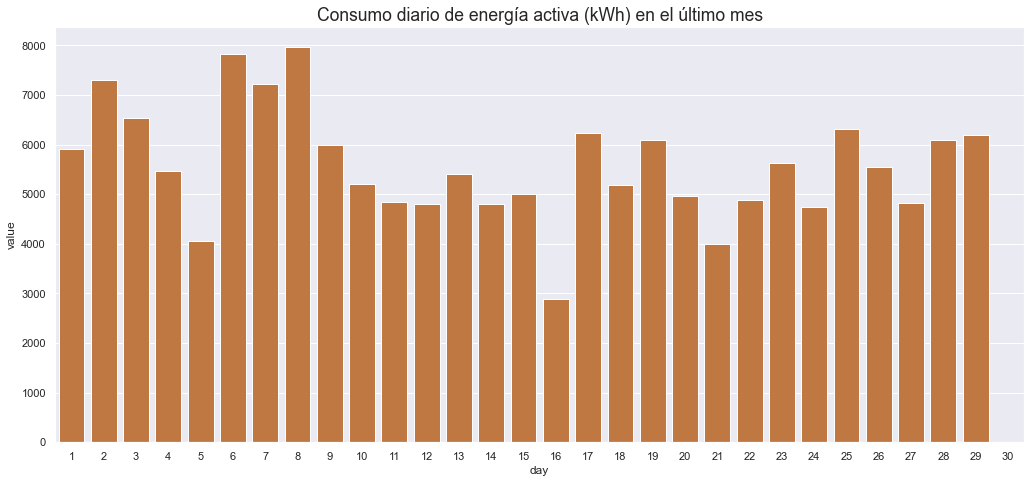

In [21]:
sns_bar_1 = sns.barplot(x="day", y="value", data=df_st_total_ea_daily, color=lst_big_colors[0])
sns_bar_1.set_title("Consumo diario de energía activa (kWh) en el último mes", fontsize=17.5)
plt.show()

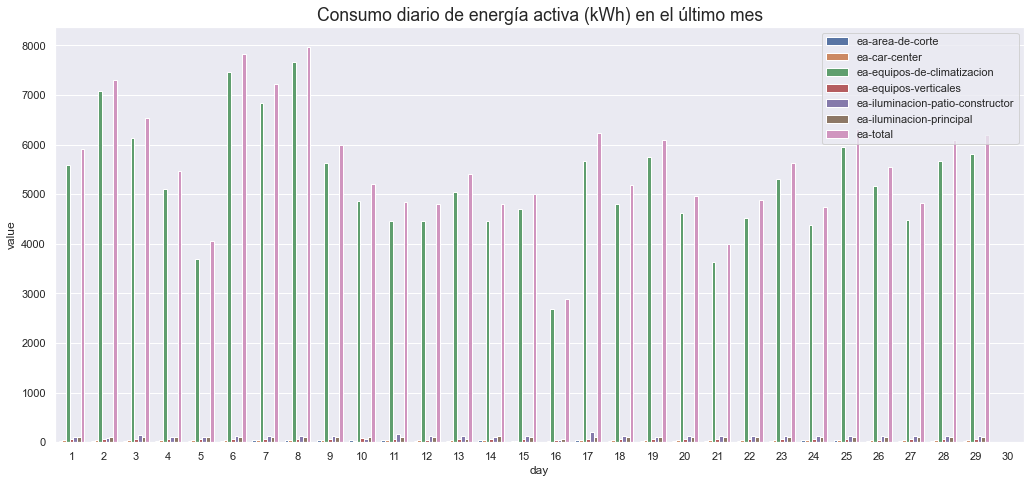

In [22]:
sns_bar_2 = sns.barplot(x="day", y="value", hue="variable", data=pd.concat([df_st_ea_daily, df_st_total_ea_daily]))#, palette=multi_palette)
sns_bar_2.set_title("Consumo diario de energía activa (kWh) en el último mes", fontsize=17.5)
plt.legend(loc='upper right')
plt.show()

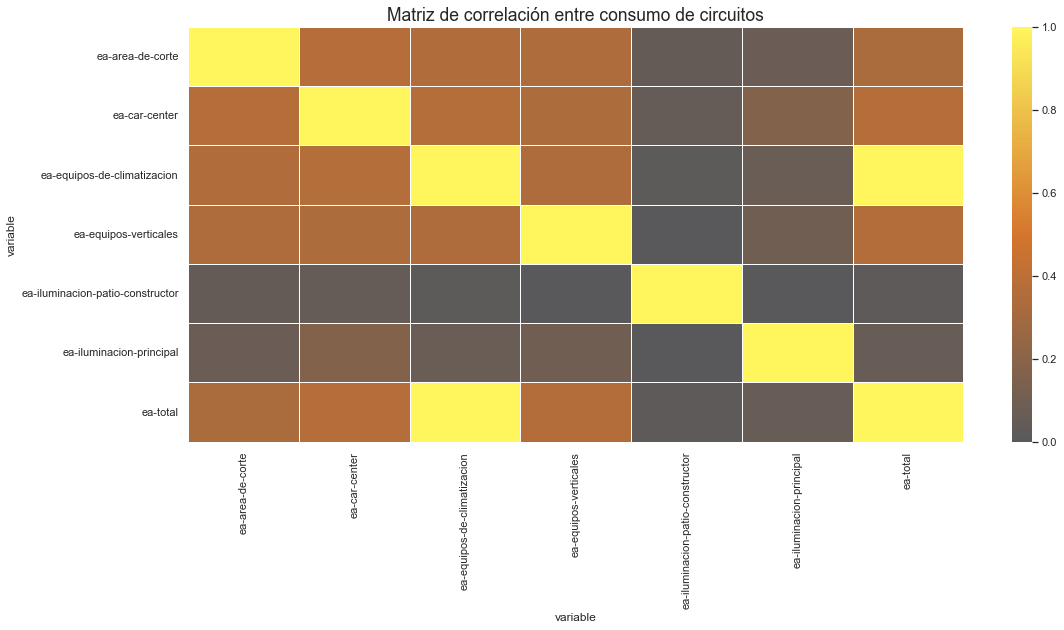

In [23]:
colorlist=[big_palette[1], big_palette[0], big_palette[4]]
newcmp = LinearSegmentedColormap.from_list('my_cmap', colors=colorlist, N=256)

is_energy = df_st['variable'].isin([TOTAL_ACTIVE_ENERGY_LABEL] + list(ACTIVE_ENERGY_LABELS))
df_st_ea_corr_matrix = df_st[is_energy].pivot(columns='variable', values='value').astype(float).corr()

norm=plt.Normalize(0,df_st_ea_corr_matrix.max().max())
sns_heat_1 = sns.heatmap(df_st_ea_corr_matrix, annot=False, cmap=newcmp, norm=norm, linewidths=.5)
sns_heat_1.set_title("Matriz de correlación entre consumo de circuitos", fontsize=17.5)
plt.show()

A continuación se muestran los consumos horarios típicos. Las regiones sombreadas representan un intervalo de confianza de 95% para la línea base.

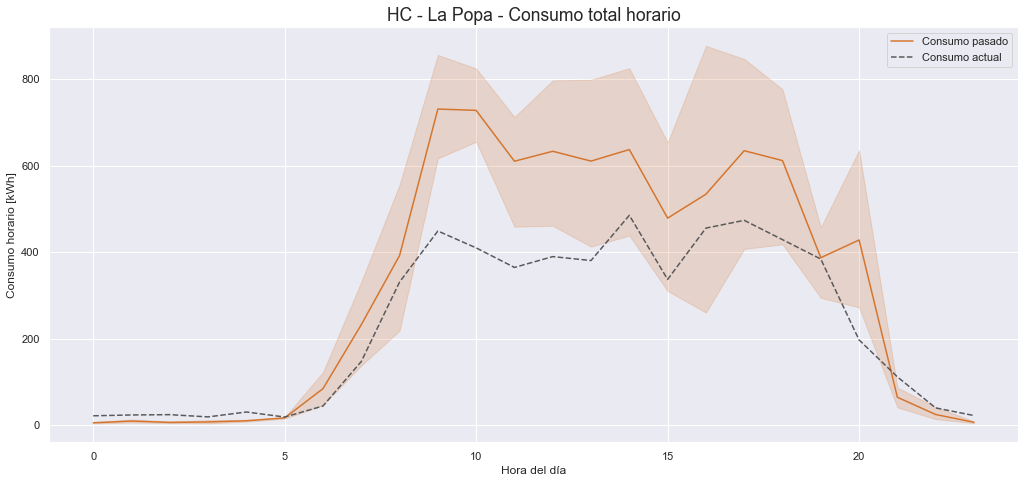

In [24]:
df_plot_bl = df_bl_total_ea_hourly
df_plot_st = df_st_total_ea_hourly
device_name = df['device_name'][0]

plt.figure()

sns.lineplot(
    x='hour',
    y='value',
    data=df_plot_bl.reset_index(), 
    ci=confidence_interval,
    estimator=np.mean,
    color=lst_big_colors[0],
    label='Consumo pasado'
)

sns.lineplot(
    x='hour',
    y='value',
    linestyle="dashed",
    data=df_plot_st.reset_index(), 
    ci=None,
    legend=False,
    estimator=np.mean,
    color=lst_big_colors[1],
    label='Consumo actual'
)
plt.title(f"{device_name} - Consumo total horario", fontsize=17.5)
plt.xlabel('Hora del día')
plt.ylabel('Consumo horario [kWh]')
plt.legend()
plt.show()

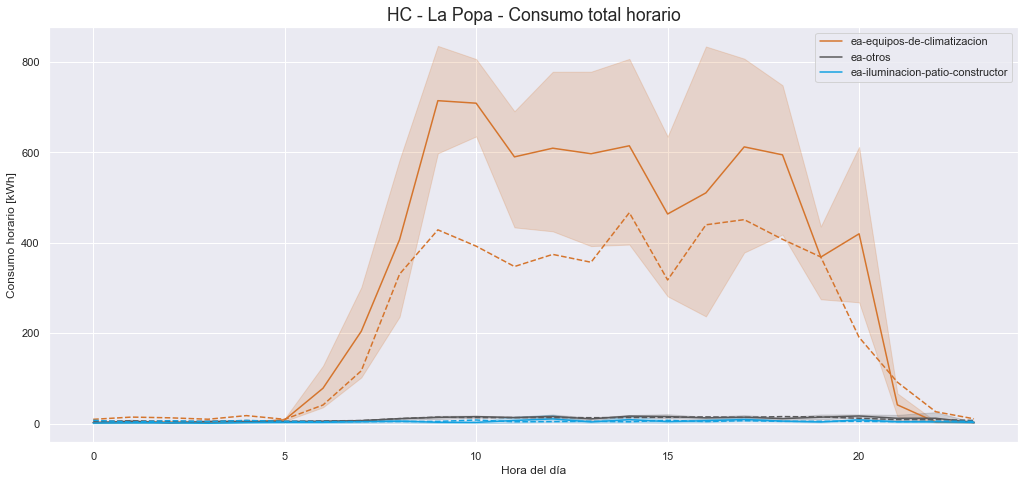

In [25]:
df_plot_bl = df_bl_ea_hourly_lumped
df_plot_st = df_st_ea_hourly_lumped
device_name = df['device_name'][0]
hue_order = hue_order_ea

plt.figure()

sns.lineplot(
    x='hour',
    y='value',
    hue='variable',
    hue_order=hue_order,
    data=df_plot_bl.reset_index(), 
    ci=confidence_interval,
    estimator=np.mean,
    palette=sns.color_palette(lst_big_colors[0:len(hue_order)])
)

sns.lineplot(
    x='hour',
    y='value',
    hue='variable',
    hue_order=hue_order,
    linestyle="dashed",
    data=df_plot_st.reset_index(), 
    ci=None,
    legend=False,
    estimator=np.mean,
    palette=sns.color_palette(lst_big_colors[0:len(hue_order)])
)
plt.title(f"{device_name} - Consumo total horario", fontsize=17.5)
plt.xlabel('Hora del día')
plt.ylabel('Consumo horario [kWh]')
plt.legend()
plt.show()

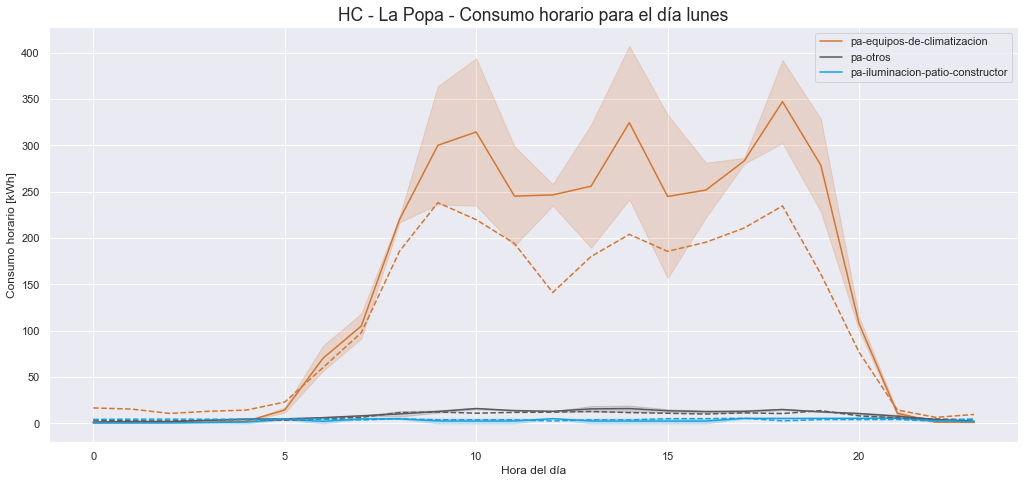

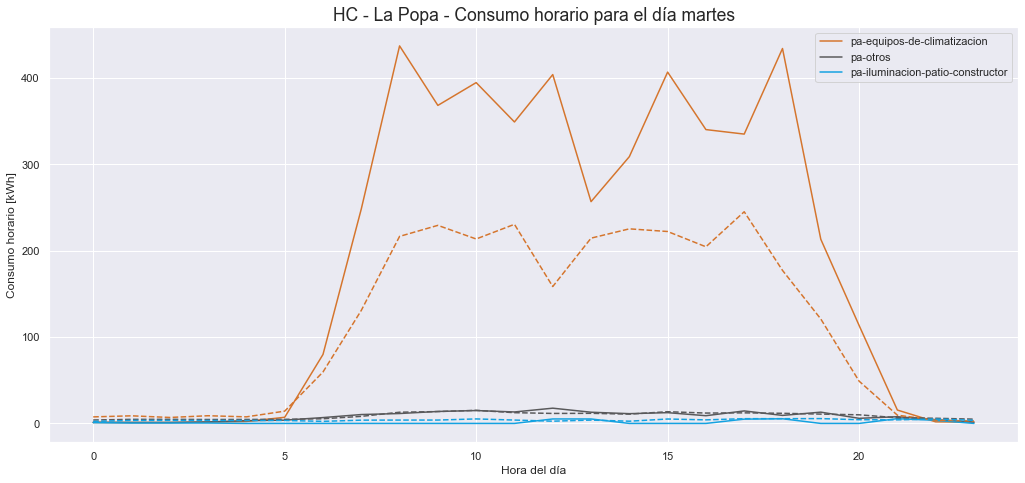

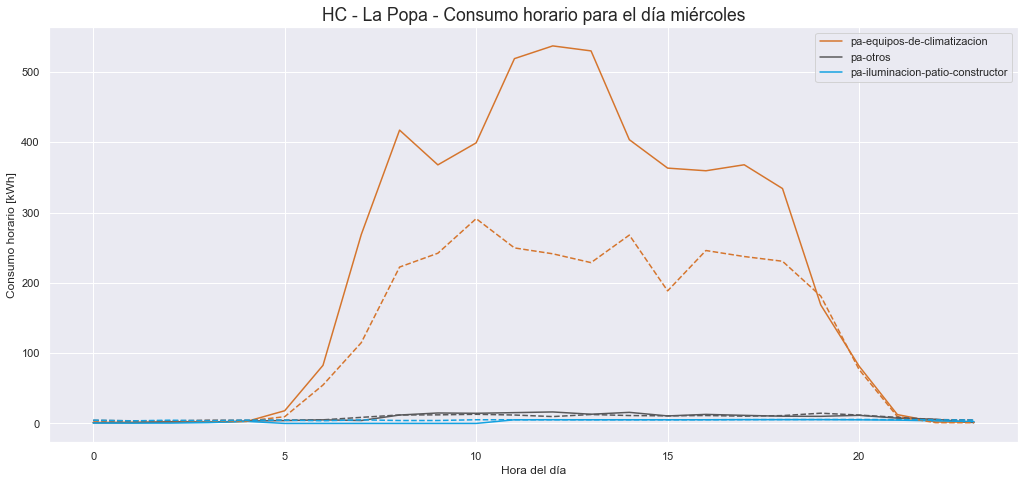

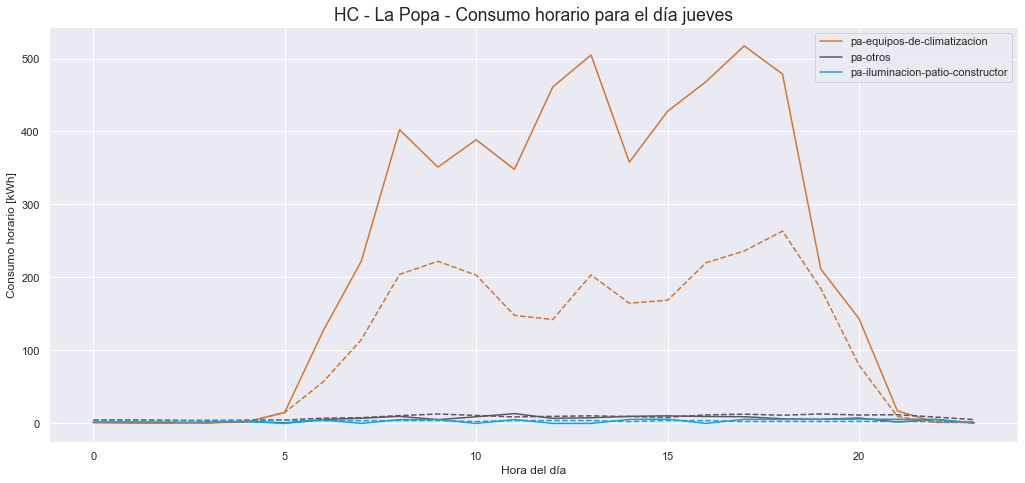

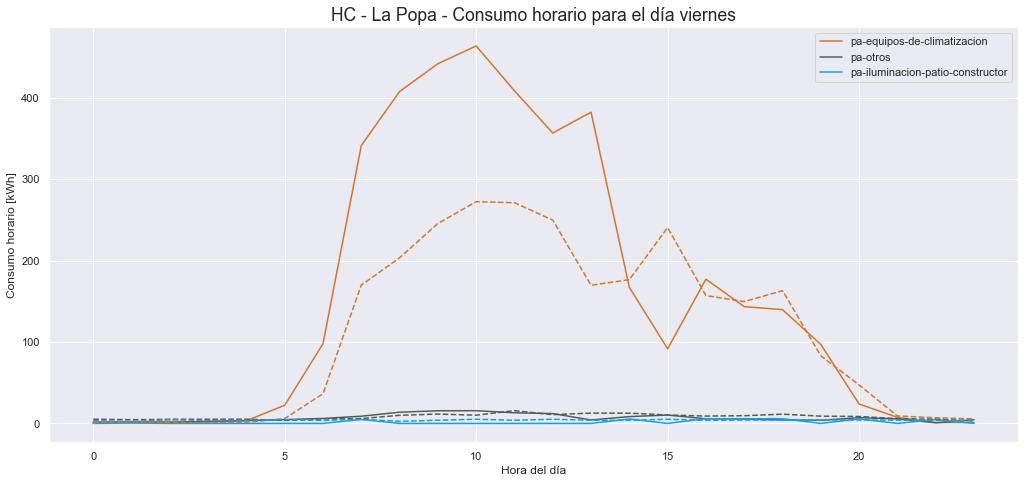

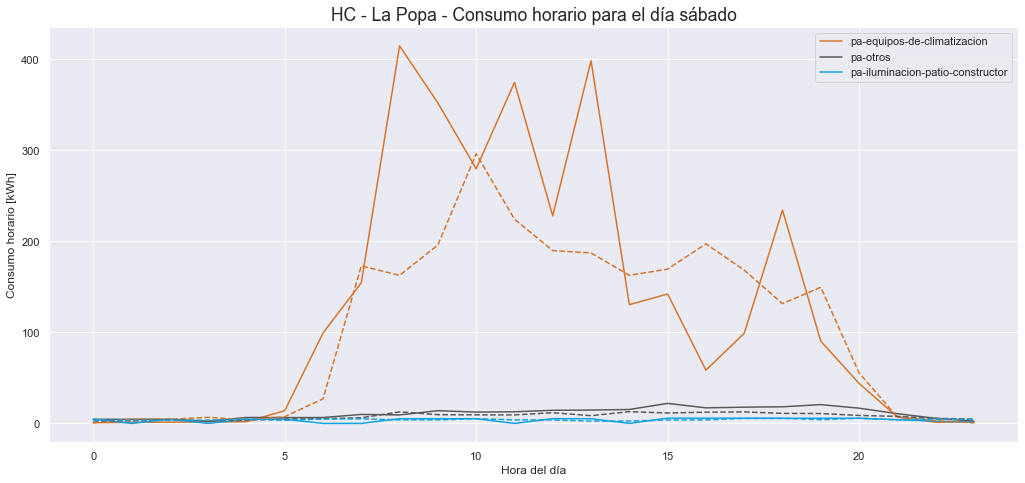

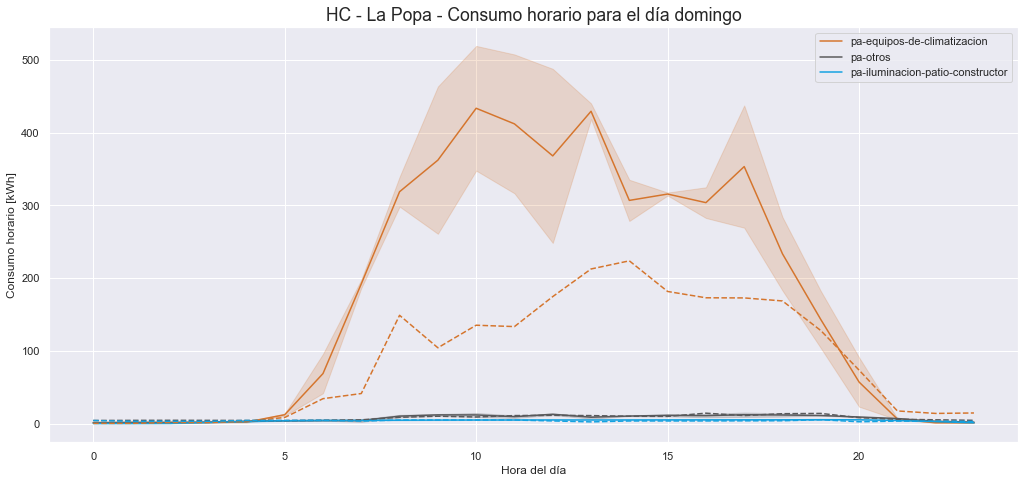

In [26]:
hue_order = hue_order_pa
for day in dct_dow.values():
    df_plot_bl = df_bl_pa_hourly_lumped[(df_bl_pa_hourly_lumped['dow']==day)]
    df_plot_st = df_st_pa_hourly_lumped[(df_st_pa_hourly_lumped['dow']==day)]

    plt.figure()
    device_name = df['device_name'][0]
    sns.lineplot(
        x='hour',
        y='value',
        hue='variable',
        hue_order=hue_order,
        data=df_plot_bl.reset_index(), 
        ci=confidence_interval,
        estimator=np.mean,
        palette=sns.color_palette(lst_big_colors[0:len(hue_order)])
    )

    sns.lineplot(
        x='hour',
        y='value',
        hue='variable',
        hue_order=hue_order,
        linestyle="dashed",
        data=df_plot_st.reset_index(), 
        ci=None,
        legend=False,
        estimator=np.mean,
        palette=sns.color_palette(lst_big_colors[0:len(hue_order)])
    )
    plt.title(f"{device_name} - Consumo horario para el día {day}", fontsize=17.5)
    plt.xlabel('Hora del día')
    plt.ylabel('Consumo horario [kWh]')
    plt.legend()
    plt.show()

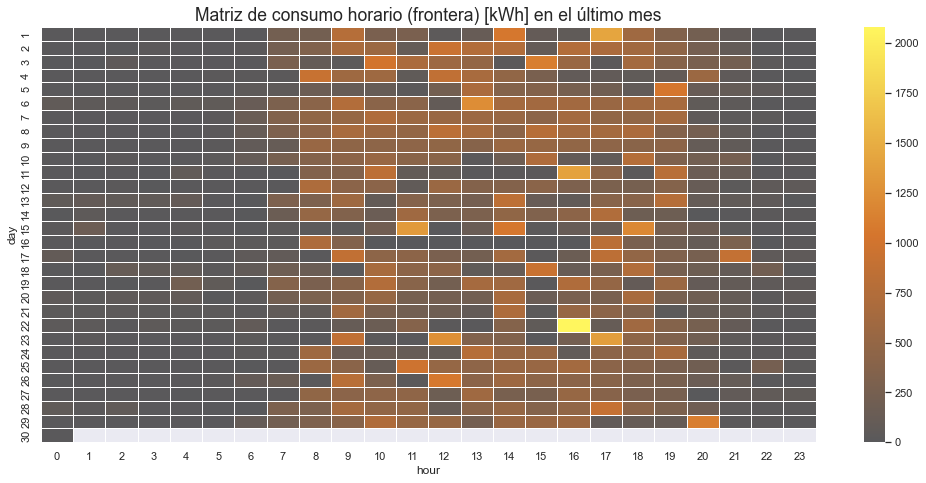

In [27]:
colorlist=[big_palette[1], big_palette[0], big_palette[4]]
newcmp = LinearSegmentedColormap.from_list('my_cmap', colors=colorlist, N=256)


b = df_st_total_ea_hourly[["day","hour", "value"]]
matrix = b.pivot("day", "hour", "value")
matrix = matrix.astype(float)
norm=plt.Normalize(0,matrix.max().max())
sns_heat_2 = sns.heatmap(matrix, annot=False, cmap=newcmp, norm=norm, linewidths=.5)
sns_heat_2.set_title("Matriz de consumo horario (frontera) [kWh] en el último mes", fontsize=17.5)

plt.show()

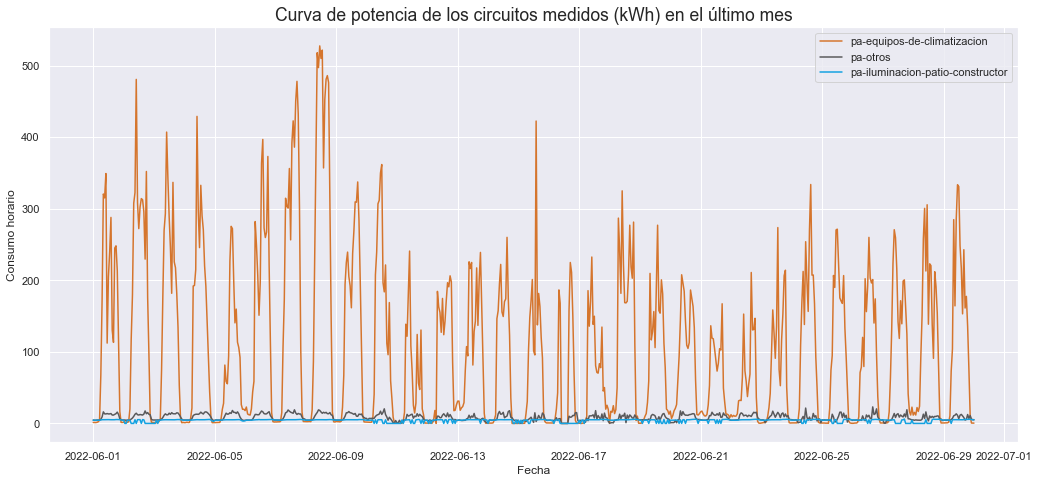

In [28]:
df_plot = df_st_pa_hourly_lumped
hue_order = hue_order_pa

sns.lineplot(
    x='datetime',
    y='value',
    hue='variable',
    hue_order=hue_order,
    linestyle="solid",
    data=df_plot.reset_index(), 
    ci=None,
    # legend=True,
    palette=sns.color_palette(lst_big_colors[0:len(hue_order)]),
    # label=" aa [kWh]"
)

plt.title("Curva de potencia de los circuitos medidos (kWh) en el último mes", fontsize=17.5)
plt.xlabel('Fecha')
plt.ylabel('Consumo horario')
plt.legend()
plt.show()


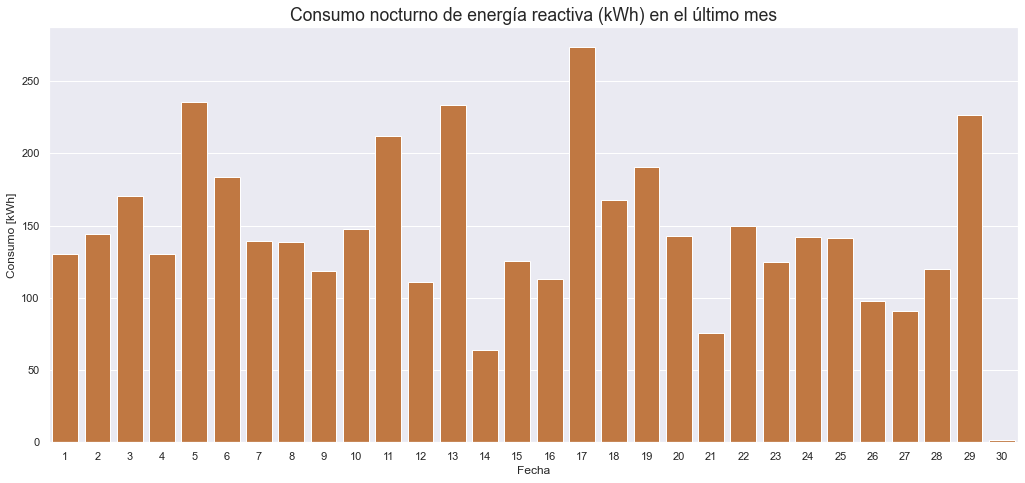

Durante el mes pasado se consumió un total de:  26054.92 kWh fuera del horario establecido


In [29]:
sns.barplot(
        x='day',
        y='value',
        hue=None,
        # linestyle="dashed",
        data=df_st_ea_night_daily, 
        ci=None,
        color=lst_big_colors[0],
    )
plt.title("Consumo nocturno de energía reactiva (kWh) en el último mes", fontsize=17.5)
plt.xlabel('Fecha')
plt.ylabel('Consumo [kWh]')
plt.show()


consumo_nocturno = round(df_st_ea_night_daily["value"].sum(),2)

print("Durante el mes pasado se consumió un total de: ", consumo_nocturno, "kWh fuera del horario establecido")